In [ ]:
import os
import pandas as pd
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import numpy as np
from sklearn.model_selection import train_test_split


### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/Data/rezised_dataset"

file_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

label2idx = {label: idx for idx, label in enumerate(sorted(set(df['label'])))}
df['label_idx'] = df['label'].map(label2idx)

# Split into labeled and unlabeled
df_labeled, df_unlabeled = train_test_split(df, test_size=0.7, stratify=df['label_idx'], random_state=42)
df_unlabeled = df_unlabeled.reset_index(drop=True)
df_labeled = df_labeled.reset_index(drop=True)


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
ROOT_DIR = "/content/drive/MyDrive/Data/rezised_dataset"
if not os.path.exists(ROOT_DIR):
    print(f"Warning: {ROOT_DIR} not found. Using a dummy directory structure for testing.")
    ROOT_DIR = "dummy_dataset"
    os.makedirs(os.path.join(ROOT_DIR, "ClassA"), exist_ok=True)
    os.makedirs(os.path.join(ROOT_DIR, "ClassB"), exist_ok=True)
    os.makedirs(os.path.join(ROOT_DIR, "ClassC"), exist_ok=True)
    for i in range(80):
        Image.new('RGB', (100, 100), color = 'red').save(os.path.join(ROOT_DIR, "ClassA", f"a{i}.jpg"))
        Image.new('RGB', (100, 100), color = 'blue').save(os.path.join(ROOT_DIR, "ClassB", f"b{i}.jpg"))
        Image.new('RGB', (100, 100), color = 'green').save(os.path.join(ROOT_DIR, "ClassC", f"c{i}.jpg"))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# MixMatch Hyperparameters
BATCH_SIZE_LABELED = 8
BATCH_SIZE_UNLABELED = 8
K_AUGMENTATIONS = 1        # Number of augmentations for each unlabeled sample
ALPHA_MIXUP = 0.75
LAMBDA_U_MAX = 75.0
RAMPUP_EPOCHS = 16
TEMPERATURE_SHARPEN = 0.5

# General Training Hyperparameters
NUM_EPOCHS = 25
LR = 3e-4

# Data Split Ratios
VAL_SIZE = 0.15
TEST_SIZE = 0.15
LABELED_RATIO_OF_TRAIN_POOL = 0.3

# --- 1. Data Loading and Preprocessing ---
file_paths = []
labels_str = []
for class_name in os.listdir(ROOT_DIR):
    class_dir = os.path.join(ROOT_DIR, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(class_dir, image_name))
                labels_str.append(class_name)

if not file_paths:
    raise ValueError(f"No images found in {ROOT_DIR}. Please check the path and image extensions.")

df = pd.DataFrame({'file_path': file_paths, 'label_str': labels_str})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

label_set = sorted(set(df['label_str']))
label2idx = {label: idx for idx, label in enumerate(label_set)}
idx2label = {idx: label for label, idx in label2idx.items()}
NUM_CLASSES = len(label2idx)
df['label_idx'] = df['label_str'].map(label2idx)
print(f"Total images: {len(df)}, Classes: {NUM_CLASSES}, Mapping: {label2idx}")

# --- Data Splitting ---
# (Using the robust splitting logic from previous examples)
min_samples_per_class_overall = max(5, K_AUGMENTATIONS * 2)
df_counts = df['label_idx'].value_counts()
can_stratify_properly = not (df_counts < min_samples_per_class_overall).any() and len(df) >= NUM_CLASSES * 10

if not can_stratify_properly:
    print("Warning: Dataset too small or class imbalance prevents robust stratified splitting for SSL.")
    # Fallback to simpler split if necessary (e.g., mostly labeled, minimal unlabeled/val/test)
    df_labeled = df.sample(frac=0.8, random_state=42)
    df_temp = df.drop(df_labeled.index)
    df_val = df_temp.sample(frac=0.5, random_state=42)
    df_test = df_temp.drop(df_val.index)
    df_unlabeled = pd.DataFrame(columns=df.columns) # No unlabeled in extreme fallback
    print("Using fallback split due to data constraints.")
else:
    df_remaining, df_test = train_test_split(df, test_size=TEST_SIZE, stratify=df['label_idx'], random_state=42)
    relative_val_size = VAL_SIZE / (1.0 - TEST_SIZE)
    df_train_pool, df_val = train_test_split(df_remaining, test_size=relative_val_size, stratify=df_remaining['label_idx'], random_state=42)

    required_labeled_samples = BATCH_SIZE_LABELED
    required_unlabeled_samples = BATCH_SIZE_UNLABELED * K_AUGMENTATIONS

    if len(df_train_pool) * LABELED_RATIO_OF_TRAIN_POOL < required_labeled_samples or \
       len(df_train_pool) * (1 - LABELED_RATIO_OF_TRAIN_POOL) < required_unlabeled_samples :
        print(f"Warning: Train pool (size {len(df_train_pool)}) too small for desired SSL split ratios. Adjusting.")
        # Prioritize having some labeled data if pool is very small
        if len(df_train_pool) > required_labeled_samples + required_unlabeled_samples:
             df_labeled, df_unlabeled = train_test_split(
                df_train_pool,
                train_size=max(required_labeled_samples, int(len(df_train_pool) * LABELED_RATIO_OF_TRAIN_POOL)), # Ensure enough labeled
                stratify=df_train_pool['label_idx'],
                random_state=42
            )
        else: # Not enough for both, make all labeled, no unlabeled for MixMatch
            df_labeled = df_train_pool.copy()
            df_unlabeled = pd.DataFrame(columns=df_train_pool.columns)
    else:
        try:
            df_labeled, df_unlabeled = train_test_split(
                df_train_pool,
                test_size=(1.0 - LABELED_RATIO_OF_TRAIN_POOL), # test_size = unlabeled_ratio
                stratify=df_train_pool['label_idx'],
                random_state=42
            )
        except ValueError: # Stratification might fail if a class has only 1 sample in df_train_pool
             print(f"Warning: Stratification failed for labeled/unlabeled split. Adjusting.")
             df_labeled = df_train_pool.sample(frac=LABELED_RATIO_OF_TRAIN_POOL, random_state=42) # Non-stratified
             df_unlabeled = df_train_pool.drop(df_labeled.index)


df_labeled = df_labeled.reset_index(drop=True)
df_unlabeled = df_unlabeled.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(f"Data split: Labeled Train={len(df_labeled)}, Unlabeled Train={len(df_unlabeled)}, Val={len(df_val)}, Test={len(df_test)}")

# --- 2. Transforms ---
# Strong augmentation ->  (labeled and unlabeled)
transform_train_mixmatch = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # MixMatch often uses slightly less aggressive crop initially
    transforms.RandomHorizontalFlip(),
    # Consider adding RandAugment or TrivialAugment for stronger augmentation if needed
    # transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_eval = transforms.Compose([ # For validation and test
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Custom Dataset ---
class MixMatchDataset(Dataset):
    def __init__(self, dataframe, transform, num_augmentations=1):
        self.dataframe = dataframe
        self.transform = transform
        self.num_augmentations = num_augmentations # For unlabeled data, K augmentations

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        label = row['label_idx']

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_path}. Using blank image.")
            image = Image.new('RGB', (224, 224), color='black')

        if self.num_augmentations > 1: # For unlabeled data needing K augmentations
            return [self.transform(image) for _ in range(self.num_augmentations)], label
        else: # For labeled data or K=1 unlabeled
            return self.transform(image), label

# --- 4. DenseNet201 Model  ---
def create_densenet201_model(num_classes, pretrained=True):
    model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1 if pretrained else None)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

densenet_model = create_densenet201_model(NUM_CLASSES).to(DEVICE)

# --- 5. Loss Functions and Optimizer ---
optimizer = optim.Adam(densenet_model.parameters(), lr=LR)

# --- 6. MixMatch Helper Functions ---
def sharpen(p, T=TEMPERATURE_SHARPEN):
    """Sharpen a probability distribution."""
    if T == 0: return p # Avoid division by zero if T is accidentally 0
    p_sharpened = p**(1./T)
    return p_sharpened / p_sharpened.sum(dim=1, keepdim=True)

def mixup_data(x, y, alpha=ALPHA_MIXUP, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixmatch_loss(preds_mixed, targets_a, targets_b, lam, lambda_u_weight, batch_size_labeled):
    """
    Calculates MixMatch loss.
    preds_mixed: Predictions from the model on the mixed batch.
    targets_a, targets_b: The two sets of targets (one-hot or prob dists) used in mixup.
    lam: The mixup lambda.
    lambda_u_weight: Weight for the unlabeled component.
    batch_size_labeled: Original size of the labeled batch portion.
    """
    # Calculate cross-entropy for soft targets: -sum(target * log_softmax(pred))
    log_probs = F.log_softmax(preds_mixed, dim=1)
    loss_per_sample = -torch.sum( (lam * targets_a + (1 - lam) * targets_b) * log_probs, dim=1)

    # Separate for labeled and unlabeled conceptual parts
    loss_x = loss_per_sample[:batch_size_labeled].mean()
    loss_u = loss_per_sample[batch_size_labeled:].mean() if len(loss_per_sample) > batch_size_labeled else torch.tensor(0.0).to(DEVICE)

    return loss_x + lambda_u_weight * loss_u

# --- 7. Lambda_U Ramp-up ---
def get_lambda_u(epoch, max_lambda_u=LAMBDA_U_MAX, rampup_epochs=RAMPUP_EPOCHS):
    if epoch >= rampup_epochs:
        return max_lambda_u
    if rampup_epochs == 0 : return max_lambda_u
    return max_lambda_u * (epoch / rampup_epochs)

# --- 8. DataLoaders ---
# drop_last=True is important for consistent batch sizes, especially for concatenation
labeled_loader, unlabeled_loader, val_loader, test_loader = None, None, None, None
if len(df_labeled) >= BATCH_SIZE_LABELED :
    labeled_dataset = MixMatchDataset(df_labeled, transform=transform_train_mixmatch, num_augmentations=1)
    labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
else: print(f"Not enough labeled samples ({len(df_labeled)}) for BATCH_SIZE_LABELED ({BATCH_SIZE_LABELED}). No labeled_loader.")

if len(df_unlabeled) >= BATCH_SIZE_UNLABELED:
    unlabeled_dataset = MixMatchDataset(df_unlabeled, transform=transform_train_mixmatch, num_augmentations=K_AUGMENTATIONS)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE_UNLABELED, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
else: print(f"Not enough unlabeled samples ({len(df_unlabeled)}) for BATCH_SIZE_UNLABELED ({BATCH_SIZE_UNLABELED}). No unlabeled_loader.")

if len(df_val) > 0:
    val_dataset = MixMatchDataset(df_val, transform=transform_eval, num_augmentations=1)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=False, num_workers=2, pin_memory=True)
if len(df_test) > 0:
    test_dataset = MixMatchDataset(df_test, transform=transform_eval, num_augmentations=1)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=False, num_workers=2, pin_memory=True)

if not labeled_loader:
    print("ERROR: Labeled data loader is essential for MixMatch. Exiting.")
    exit()

# --- 9. Evaluation Function ---
@torch.no_grad()
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    total_loss_eval = 0
    criterion_eval = nn.CrossEntropyLoss()

    if loader is None or len(loader.dataset) == 0: return 0.0, 0.0, [], []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion_eval(outputs, targets)
        total_loss_eval += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss_eval / len(loader.dataset) if len(loader.dataset) > 0 else 0
    accuracy = accuracy_score(all_targets, all_preds) if all_targets else 0.0
    return avg_loss, accuracy

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
# Starting MixMatch Training with DenseNet201 (it is the best model, in my case)

for epoch in range(NUM_EPOCHS):
    densenet_model.train()
    epoch_loss = 0.0
    num_iter_epoch = len(labeled_loader)

    # Create iterators
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader) if unlabeled_loader else None

    progress_bar = tqdm(range(num_iter_epoch), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    current_lambda_u = get_lambda_u(epoch)

    for batch_idx in progress_bar:
        optimizer.zero_grad()

        # 1. Get Labeled Data
        inputs_x, targets_x = next(labeled_iter)
        inputs_x, targets_x = inputs_x.to(DEVICE), targets_x.to(DEVICE)
        targets_x_onehot = F.one_hot(targets_x, NUM_CLASSES).float()

        current_batch_loss = torch.tensor(0.0).to(DEVICE)

        if unlabeled_iter and current_lambda_u > 0:
            # 2. Get Unlabeled Data (K augmentations) and Guess Labels
            try:
                # If K_AUGMENTATIONS > 1, inputs_u_list is a list of tensors
                inputs_u_list, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                inputs_u_list, _ = next(unlabeled_iter)

            if not isinstance(inputs_u_list, list): # If K_AUGMENTATIONS = 1
                inputs_u_list = [inputs_u_list.to(DEVICE)]
            else:
                inputs_u_list = [u.to(DEVICE) for u in inputs_u_list]

            with torch.no_grad():
                # pseudo-labels generation for each augmentation of unlabeled data
                pseudo_labels_u_list = [F.softmax(densenet_model(u_aug), dim=1) for u_aug in inputs_u_list]
                # Average pseudo-labels if K_AUGMENTATIONS > 1
                avg_pseudo_labels_u = torch.stack(pseudo_labels_u_list).mean(dim=0)
                # Sharpen averaged pseudo-labels
                targets_u_sharpened = sharpen(avg_pseudo_labels_u, T=TEMPERATURE_SHARPEN)

            # Prepare for the MixUp, we use one of the augmentations (e.g., the first) from inputs_u_list
            inputs_for_mixup = torch.cat((inputs_x, inputs_u_list[0]), dim=0)
            targets_for_mixup = torch.cat((targets_x_onehot, targets_u_sharpened), dim=0)
        else: # It is Supervised only (no unlabeled data or lambda_u is 0)
            inputs_for_mixup = inputs_x
            targets_for_mixup = targets_x_onehot
            current_lambda_u = 0

        # 3. Apply MixUp
        mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs_for_mixup, targets_for_mixup, alpha=ALPHA_MIXUP, device=DEVICE)

        # 4. Compute Predictions on Mixed Inputs
        preds_mixed = densenet_model(mixed_inputs)

        # 5. Calculate MixMatch Loss
        # The labeled batch size for the loss function is BATCH_SIZE_LABELED (original inputs_x size)
        current_batch_loss = mixmatch_loss(preds_mixed, targets_a, targets_b, lam, current_lambda_u, BATCH_SIZE_LABELED)

        if not (torch.isnan(current_batch_loss) or torch.isinf(current_batch_loss)):
            current_batch_loss.backward()
            optimizer.step()
            epoch_loss += current_batch_loss.item()
        else:
            print(f"Warning: NaN or Inf loss detected: {current_batch_loss.item()}. Skipping batch.")

        progress_bar.set_postfix({'Loss': f"{epoch_loss/(batch_idx+1):.4f}", 'Lambda_U': f"{current_lambda_u:.2f}"})

    avg_epoch_loss = epoch_loss / num_iter_epoch if num_iter_epoch > 0 else 0
    history['train_loss'].append(avg_epoch_loss)

    train_loss_eval, train_acc_eval = evaluate_model(densenet_model, labeled_loader, DEVICE)
    history['train_acc'].append(train_acc_eval)

    val_loss, val_acc = evaluate_model(densenet_model, val_loader, DEVICE)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {avg_epoch_loss:.4f}, Train Acc: {train_acc_eval:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

if test_loader:
    print("\n--- Evaluating DenseNet201 (MixMatch Trained) on Test Set ---")
    final_test_loss, final_test_acc = evaluate_model(densenet_model, test_loader, DEVICE)
    print(f"  Test Loss: {final_test_loss:.4f}")
    print(f"  Test Accuracy: {final_test_acc:.4f}")

Using device: cuda
Total images: 840, Classes: 4, Mapping: {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}
Data split: Labeled Train=176, Unlabeled Train=411, Val=127, Test=126


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 211MB/s]



--- Starting MixMatch Training with DenseNet201 ---


Epoch 1/25: 100%|██████████| 22/22 [01:22<00:00,  3.74s/it, Loss=0.8908, Lambda_U=0.00]



Epoch 1/25 - Train Loss: 0.8908, Train Acc: 0.8239 | Val Loss: 0.5625, Val Acc: 0.7559


Epoch 2/25: 100%|██████████| 22/22 [00:57<00:00,  2.63s/it, Loss=4.8341, Lambda_U=4.69]



Epoch 2/25 - Train Loss: 4.8341, Train Acc: 0.8580 | Val Loss: 0.4323, Val Acc: 0.8661


Epoch 3/25: 100%|██████████| 22/22 [00:26<00:00,  1.20s/it, Loss=8.3324, Lambda_U=9.38]



Epoch 3/25 - Train Loss: 8.3324, Train Acc: 0.9261 | Val Loss: 0.3757, Val Acc: 0.8898


Epoch 4/25: 100%|██████████| 22/22 [00:28<00:00,  1.32s/it, Loss=13.4744, Lambda_U=14.06]



Epoch 4/25 - Train Loss: 13.4744, Train Acc: 0.8920 | Val Loss: 0.3812, Val Acc: 0.9291


Epoch 5/25: 100%|██████████| 22/22 [00:14<00:00,  1.54it/s, Loss=15.4684, Lambda_U=18.75]



Epoch 5/25 - Train Loss: 15.4684, Train Acc: 0.7045 | Val Loss: 0.8843, Val Acc: 0.6693


Epoch 6/25: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s, Loss=20.2872, Lambda_U=23.44]



Epoch 6/25 - Train Loss: 20.2872, Train Acc: 0.7045 | Val Loss: 0.6640, Val Acc: 0.7480


Epoch 7/25: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s, Loss=27.0115, Lambda_U=28.12]



Epoch 7/25 - Train Loss: 27.0115, Train Acc: 0.8182 | Val Loss: 0.4855, Val Acc: 0.8583


Epoch 8/25: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s, Loss=29.4799, Lambda_U=32.81]



Epoch 8/25 - Train Loss: 29.4799, Train Acc: 0.8750 | Val Loss: 0.4885, Val Acc: 0.8583


Epoch 9/25: 100%|██████████| 22/22 [00:08<00:00,  2.72it/s, Loss=31.3258, Lambda_U=37.50]



Epoch 9/25 - Train Loss: 31.3258, Train Acc: 0.8920 | Val Loss: 0.3613, Val Acc: 0.8740


Epoch 10/25: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s, Loss=32.2394, Lambda_U=42.19]



Epoch 10/25 - Train Loss: 32.2394, Train Acc: 0.6989 | Val Loss: 1.1108, Val Acc: 0.7008


Epoch 11/25: 100%|██████████| 22/22 [00:07<00:00,  2.81it/s, Loss=35.0373, Lambda_U=46.88]



Epoch 11/25 - Train Loss: 35.0373, Train Acc: 0.7500 | Val Loss: 0.5058, Val Acc: 0.7480


Epoch 12/25: 100%|██████████| 22/22 [00:08<00:00,  2.61it/s, Loss=41.9652, Lambda_U=51.56]



Epoch 12/25 - Train Loss: 41.9652, Train Acc: 0.5341 | Val Loss: 1.1125, Val Acc: 0.5276


Epoch 13/25: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s, Loss=54.8512, Lambda_U=56.25]



Epoch 13/25 - Train Loss: 54.8512, Train Acc: 0.7727 | Val Loss: 0.7000, Val Acc: 0.8110


Epoch 14/25: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s, Loss=46.6722, Lambda_U=60.94]



Epoch 14/25 - Train Loss: 46.6722, Train Acc: 0.8864 | Val Loss: 0.3068, Val Acc: 0.9055


Epoch 15/25: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s, Loss=55.6288, Lambda_U=65.62]



Epoch 15/25 - Train Loss: 55.6288, Train Acc: 0.6477 | Val Loss: 0.9644, Val Acc: 0.6693


Epoch 16/25: 100%|██████████| 22/22 [00:07<00:00,  2.78it/s, Loss=61.6174, Lambda_U=70.31]



Epoch 16/25 - Train Loss: 61.6174, Train Acc: 0.8807 | Val Loss: 0.4599, Val Acc: 0.8583


Epoch 17/25: 100%|██████████| 22/22 [00:07<00:00,  2.80it/s, Loss=51.7060, Lambda_U=75.00]



Epoch 17/25 - Train Loss: 51.7060, Train Acc: 0.8920 | Val Loss: 0.3866, Val Acc: 0.8425


Epoch 18/25: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s, Loss=65.7817, Lambda_U=75.00]



Epoch 18/25 - Train Loss: 65.7817, Train Acc: 0.6818 | Val Loss: 0.5876, Val Acc: 0.7008


Epoch 19/25: 100%|██████████| 22/22 [00:08<00:00,  2.56it/s, Loss=57.7363, Lambda_U=75.00]



Epoch 19/25 - Train Loss: 57.7363, Train Acc: 0.8920 | Val Loss: 0.2789, Val Acc: 0.9606


Epoch 20/25: 100%|██████████| 22/22 [00:08<00:00,  2.64it/s, Loss=54.9205, Lambda_U=75.00]



Epoch 20/25 - Train Loss: 54.9205, Train Acc: 0.8864 | Val Loss: 0.3352, Val Acc: 0.8976


Epoch 21/25: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s, Loss=57.0003, Lambda_U=75.00]



Epoch 21/25 - Train Loss: 57.0003, Train Acc: 0.8636 | Val Loss: 0.3401, Val Acc: 0.9134


Epoch 22/25: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s, Loss=56.0700, Lambda_U=75.00]



Epoch 22/25 - Train Loss: 56.0700, Train Acc: 0.6761 | Val Loss: 0.8946, Val Acc: 0.6535


Epoch 23/25: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s, Loss=54.1991, Lambda_U=75.00]



Epoch 23/25 - Train Loss: 54.1991, Train Acc: 0.7330 | Val Loss: 0.5311, Val Acc: 0.7244


Epoch 24/25: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s, Loss=58.3315, Lambda_U=75.00]



Epoch 24/25 - Train Loss: 58.3315, Train Acc: 0.8977 | Val Loss: 0.3661, Val Acc: 0.8504


Epoch 25/25: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s, Loss=53.7494, Lambda_U=75.00]



Epoch 25/25 - Train Loss: 53.7494, Train Acc: 0.8807 | Val Loss: 0.4328, Val Acc: 0.8346

--- MixMatch Training Finished ---

--- Evaluating DenseNet201 (MixMatch Trained) on Test Set ---
  Test Loss: 0.4636
  Test Accuracy: 0.8095



Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.84      0.55      0.67        38
     Class 1       1.00      1.00      1.00        16
     Class 2       0.97      0.84      0.90        37
     Class 3       0.64      0.97      0.77        35

    accuracy                           0.81       126
   macro avg       0.86      0.84      0.83       126
weighted avg       0.84      0.81      0.81       126



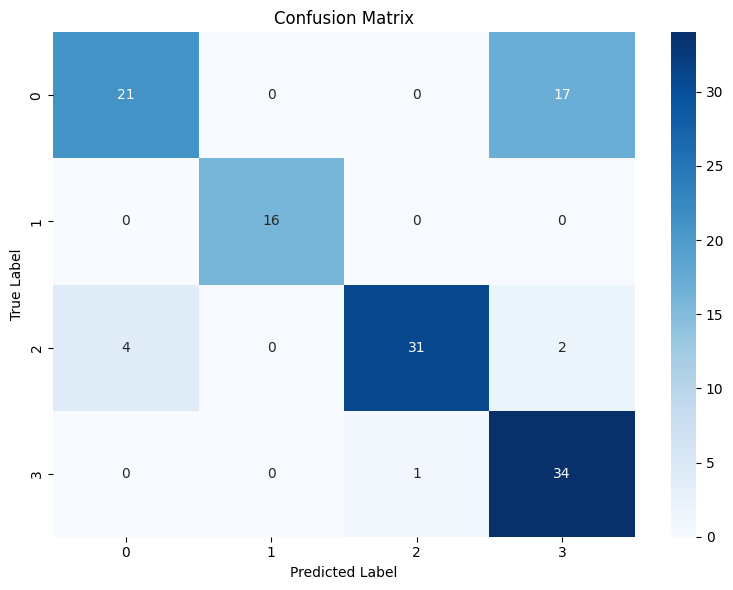

In [ ]:
#Classification Report and Confusion Matrix :
if test_loader:
    densenet_model.eval()
    all_test_preds_final, all_test_targets_final = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = densenet_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_test_preds_final.extend(preds.cpu().numpy())
            all_test_targets_final.extend(targets.cpu().numpy())

    if all_test_targets_final:
        print("\nClassification Report (Test Set):")
        if all_test_targets_final or all_test_preds_final:

             report_labels = sorted(list(set(all_test_targets_final) | set(all_test_preds_final)))
             target_names_report = [f'Class {i}' for i in report_labels]
             print(classification_report(all_test_targets_final, all_test_preds_final, target_names=target_names_report, labels=report_labels, zero_division=0))
        else:
             print("No targets or predictions available for classification report.")

        cm_labels = sorted(label2idx.values())
        cm = confusion_matrix(all_test_targets_final, all_test_preds_final, labels=cm_labels)

        # Use generic class names for confusion matrix ticks
        cm_tick_labels = [f'{i}' for i in cm_labels]

        plt.figure(figsize=(max(8, NUM_CLASSES*0.9), max(6, NUM_CLASSES*0.8)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=cm_tick_labels,
                    yticklabels=cm_tick_labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        # Ensure final_test_acc is defined or handle the case where test_loader is None
        accuracy_title = f'Accuracy: {final_test_acc:.4f}' if 'final_test_acc' in locals() else ''
        plt.title(f'Confusion Matrix')
        plt.tight_layout()
        plt.show()
    else:
        print("No test targets or predictions available for evaluation metrics.")
else:
    print("\nNo test set to evaluate.")

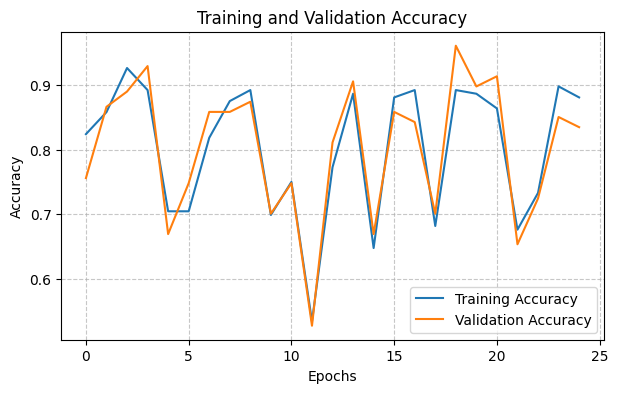

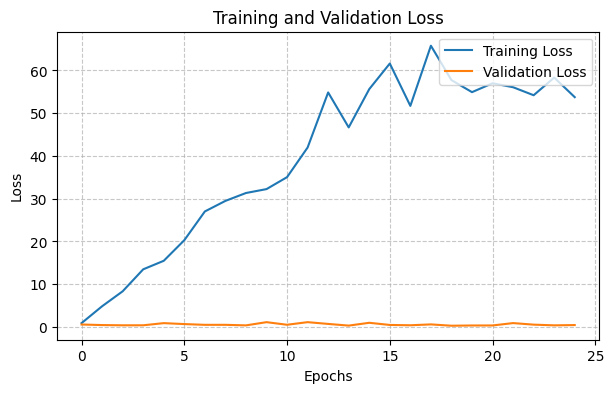

In [ ]:
acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(7, 4))
plt.plot((epochs), history['train_acc'], label='Training Accuracy')
plt.plot((epochs), history['val_acc'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# prompt: accuracy for each class
if all_test_targets_final:
    print("\nAccuracy per Class (Test Set):")
    unique_classes = sorted(list(set(all_test_targets_final)))

    for class_idx in unique_classes:
        true_positives = sum((t == class_idx and p == class_idx) for t, p in zip(all_test_targets_final, all_test_preds_final))
        total_in_class = all_test_targets_final.count(class_idx)

        accuracy = true_positives / total_in_class if total_in_class > 0 else 0.0
        class_name = idx2label[class_idx]
        print(f"  Class '{class_name}' (idx {class_idx}): {accuracy:.4f} ({true_positives}/{total_in_class})")



Accuracy per Class (Test Set):
  Class 'Bacterial Leaf Disease' (idx 0): 0.5526 (21/38)
  Class 'Dried Leaf' (idx 1): 1.0000 (16/16)
  Class 'Fungal Brown Spot Disease' (idx 2): 0.8378 (31/37)
  Class 'Healthy Leaf' (idx 3): 0.9714 (34/35)


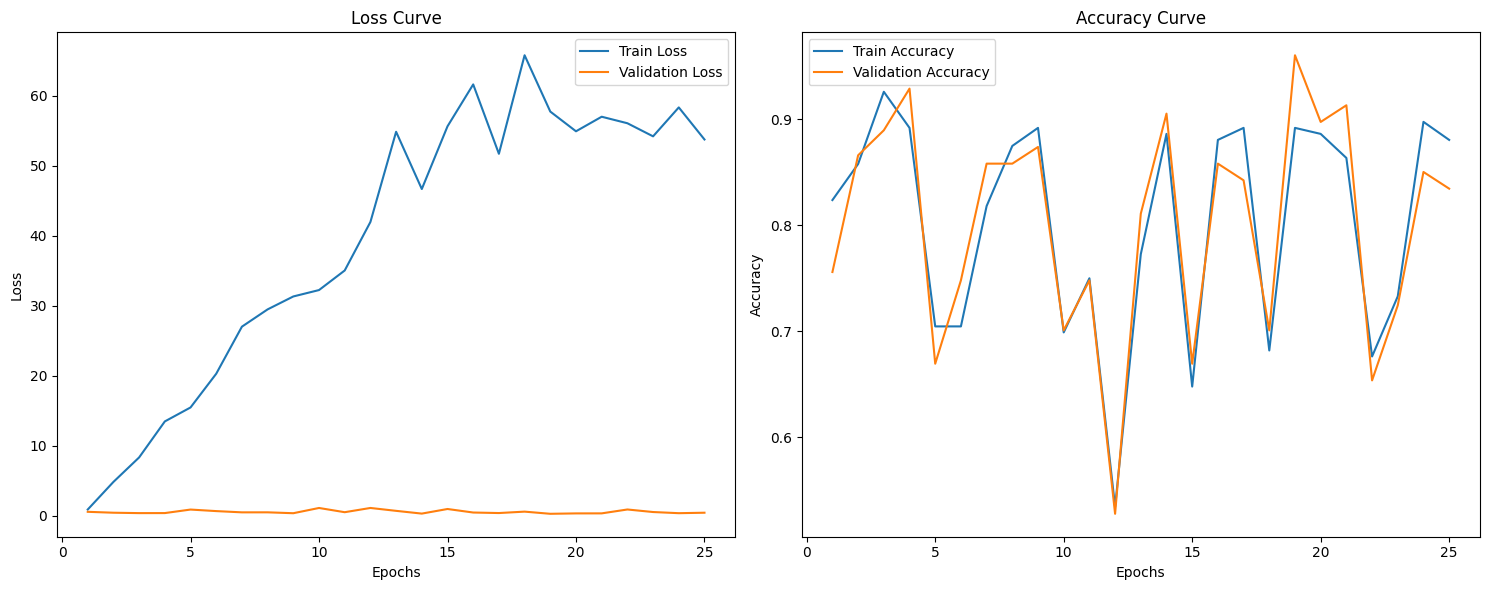

In [ ]:
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(15, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
if val_loader and history['val_loss']:
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
if val_loader and history['val_acc']:
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()